In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt
from element_eda import score_by_elt
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [4]:
# Color for plots
color_mean = 'blue'
color_lo = 'orange'
color_hi = 'green'
color_min = 'red'
color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [9]:
# # Review unperturbed elements
# elts_ast

In [10]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [11]:
# Choose which elements to search on
elts = elts_pert

In [12]:
# Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [13]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [14]:
# Review nearest asteroid to these candidate elements
# elts_near

In [15]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [16]:
# Arguments to make_ztf_batch
# thresh_deg = 1.0
thresh_deg = 2.0
# thresh_deg = 4.0
near_ast = False
regenerate = False

In [17]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [19]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [20]:
# Mixture parameters
num_hits: int = 20
R_deg: float = 0.5

In [21]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, score_by_elt=score_by_elt, num_hits=num_hits, R_deg=R_deg)

In [22]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,h,R
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,0.004412,0.008727
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,0.007027,0.008727
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,0.006236,0.008727
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,0.006647,0.008727
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,0.005598,0.008727
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,0.001981,0.008727
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,0.007921,0.008727
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,0.003156,0.008727
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,0.007348,0.008727


## Train on Perturbed Elements: Learn Mixture Parameters

In [23]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [24]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [25]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [26]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :     0.07  :   0.00 :  0.500000 :  1800.00
Std  :     1.76  :   0.00 :  0.000000 :     0.00
Min  :    -2.44  :   0.00 :  0.500000 :  1800.00
Max  :     6.76  :   0.00 :  0.500000 :  1800.00


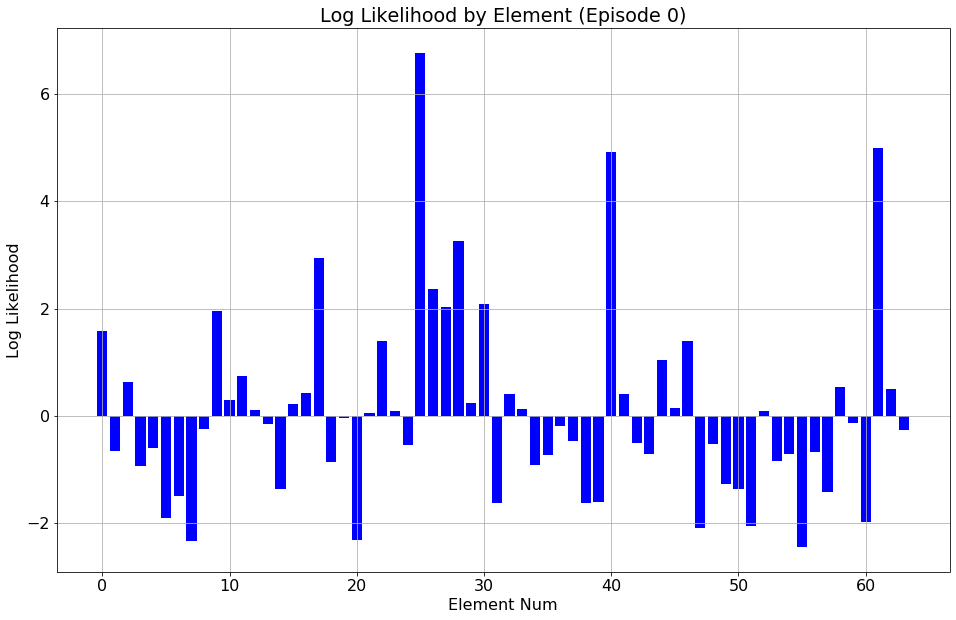

In [27]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [28]:
# Adaptive search parameters
max_batches_mixture = 2000
max_batches_element = 10000
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
min_learning_rate = None
save_at_end = True
verbose = 1

In [29]:
# Load model
model.load()
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.18  : 188.99 :  1.000000 :  3600.00


In [30]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [31]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_mixture, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    save_at_end=True,
    verbose=verbose)


********************************************************************************
Terminating: Completed 10900 batches.
********************************************************************************
Saving candidate elements DataFrame in ../data/candidate_elt/candidate_elt_7003121184606232928.h5.


In [32]:
# Report after initial training on mixture parameters
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.19  : 188.99 :  1.000000 :  3600.00


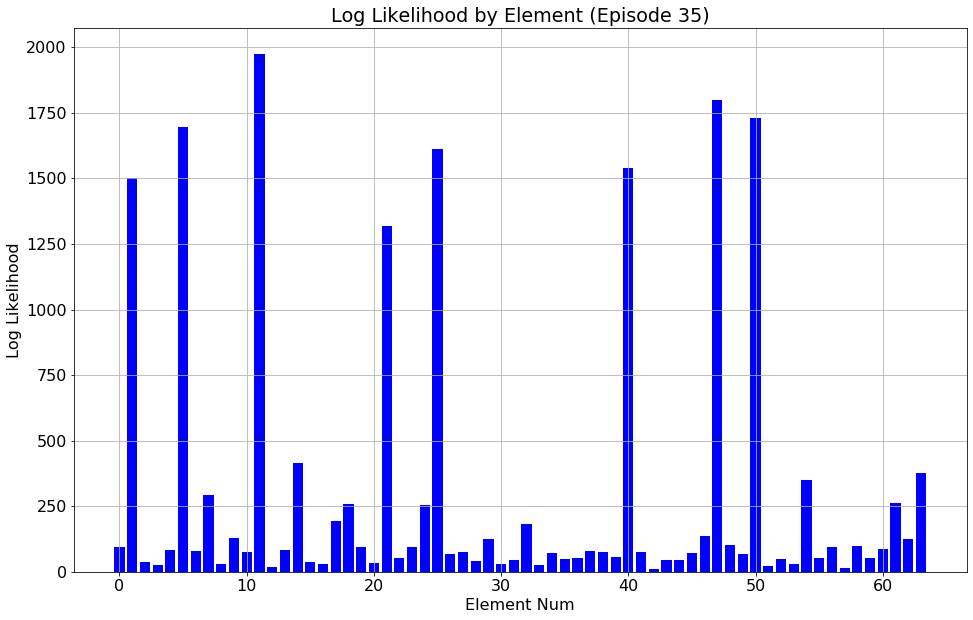

In [33]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

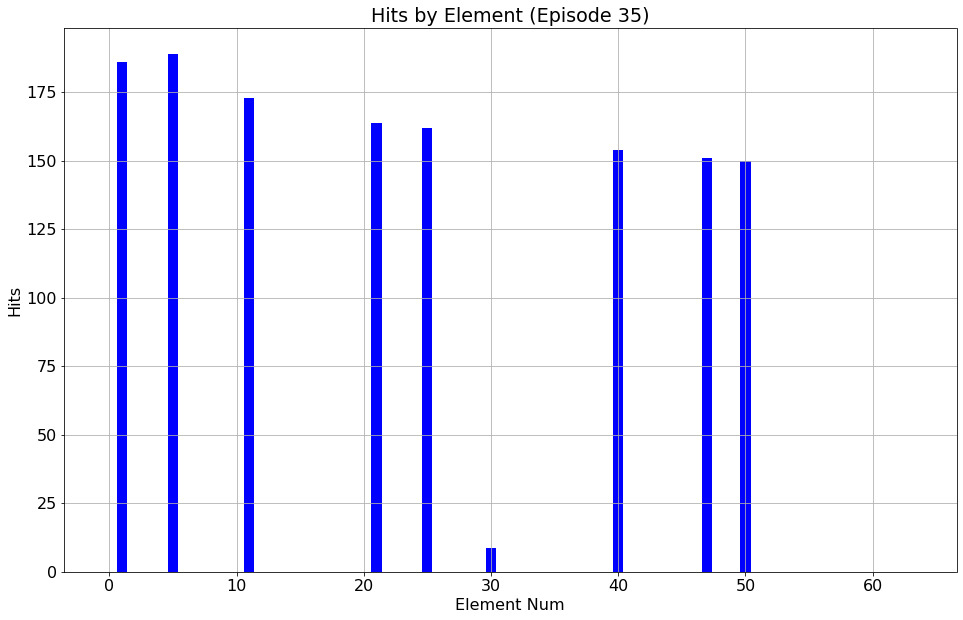

In [34]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('hits', sorted=False)

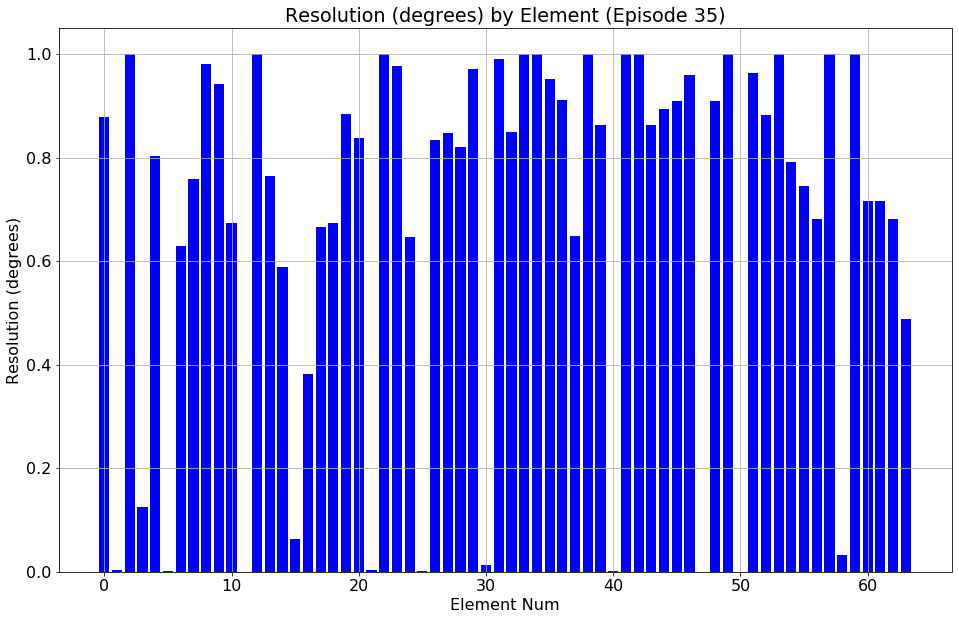

In [35]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('R_deg', sorted=False)

## Train on Perturbed Model: Joint (Elements & Mixture)

In [36]:
# Unfreeze the elements, freeze the mixture model parameters
model.thaw_candidate_elements()

In [37]:
# New smaller learning rate
learning_rate = 2.0**-14

In [38]:
# Train unperturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    min_learning_rate=min_learning_rate,
    save_at_end=False,
    verbose=verbose)


********************************************************************************
Terminating: Completed 10900 batches.
********************************************************************************


In [39]:
# Report after training
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.19  : 188.99 :  1.000000 :  3600.00


In [40]:
model.save_state()

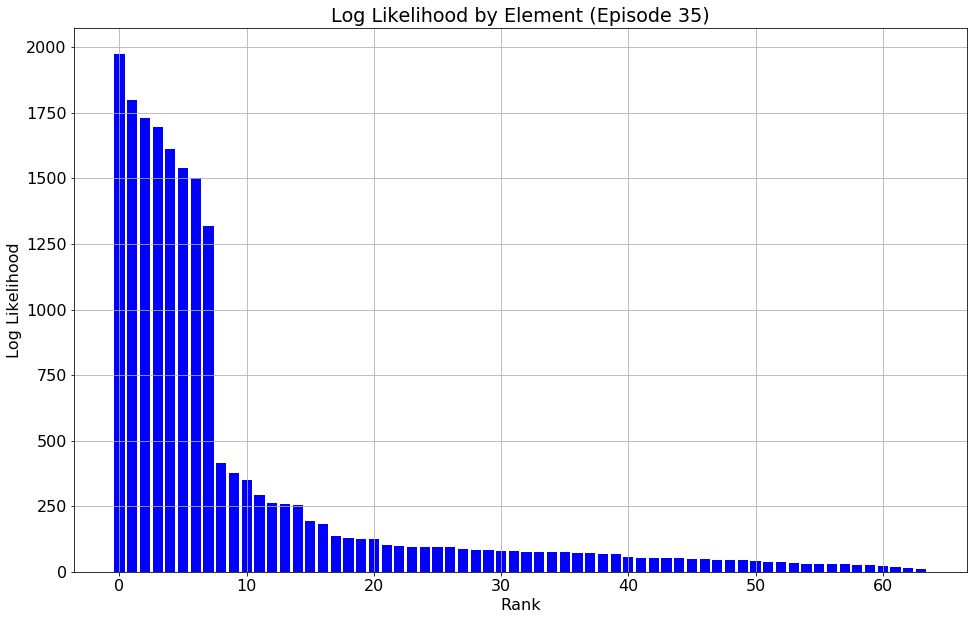

In [41]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

## Review Results Graphically

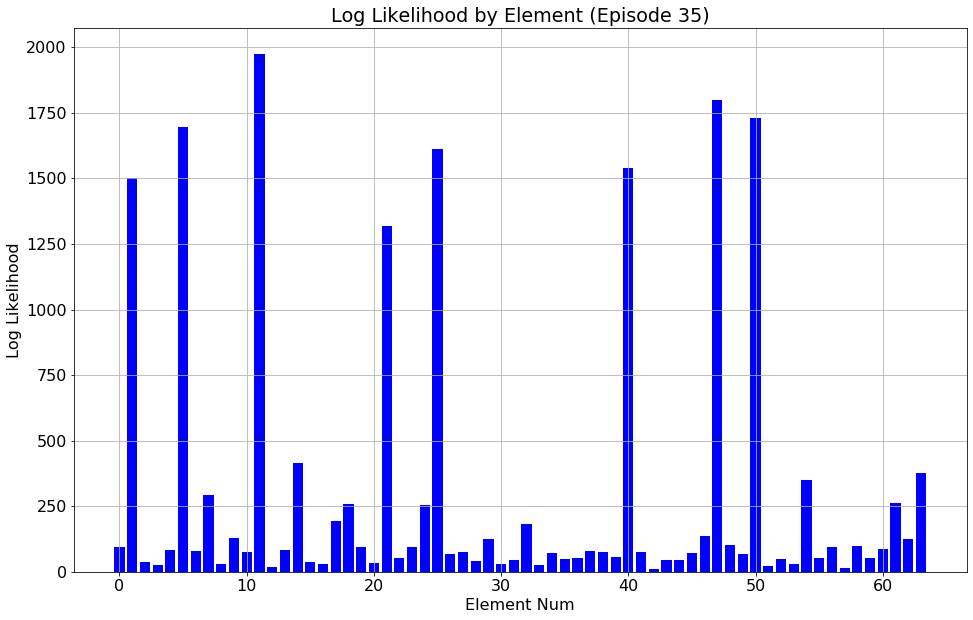

In [42]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

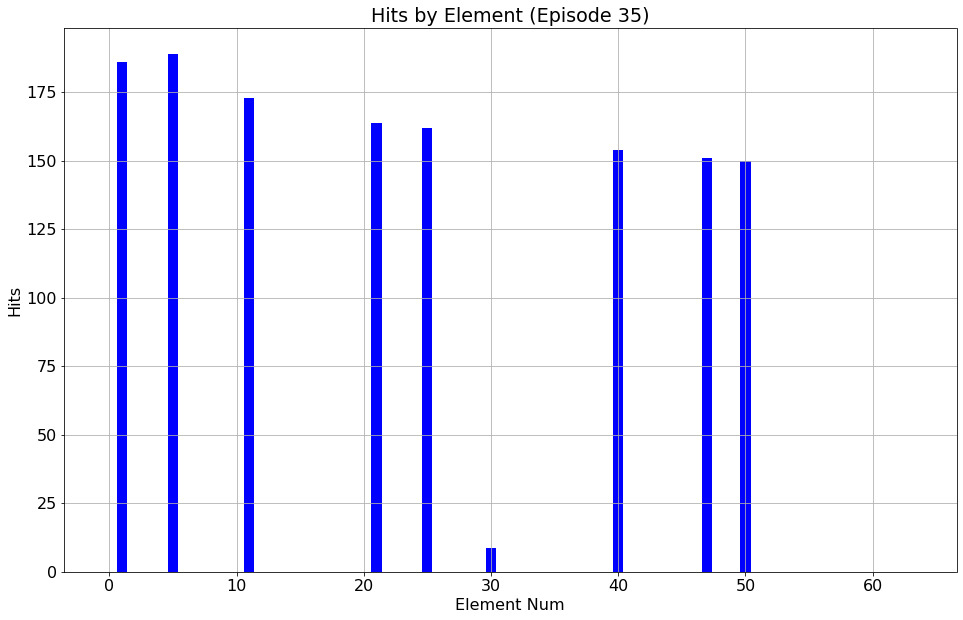

In [43]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

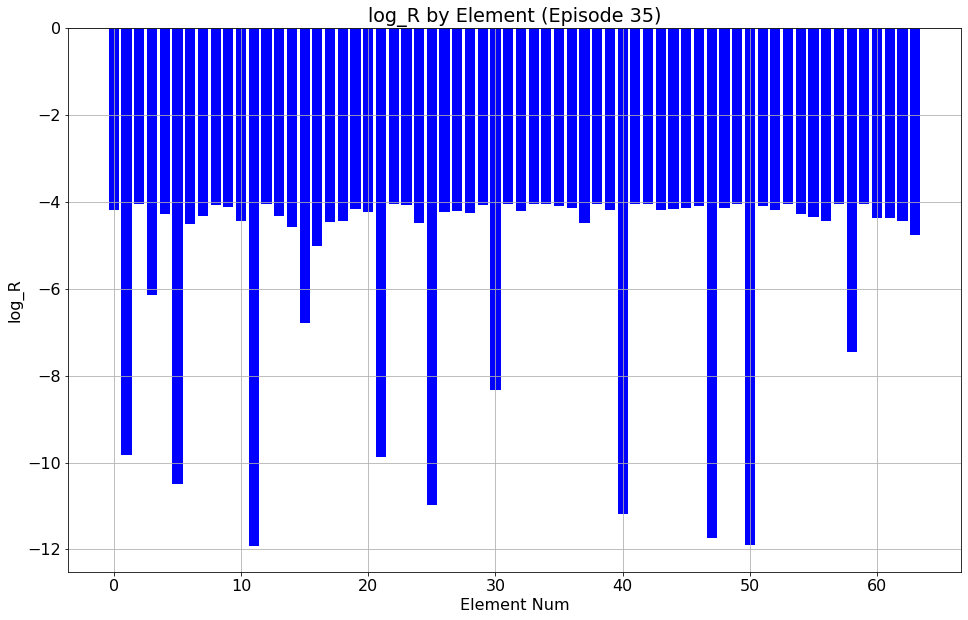

In [44]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('log_R', sorted=False)

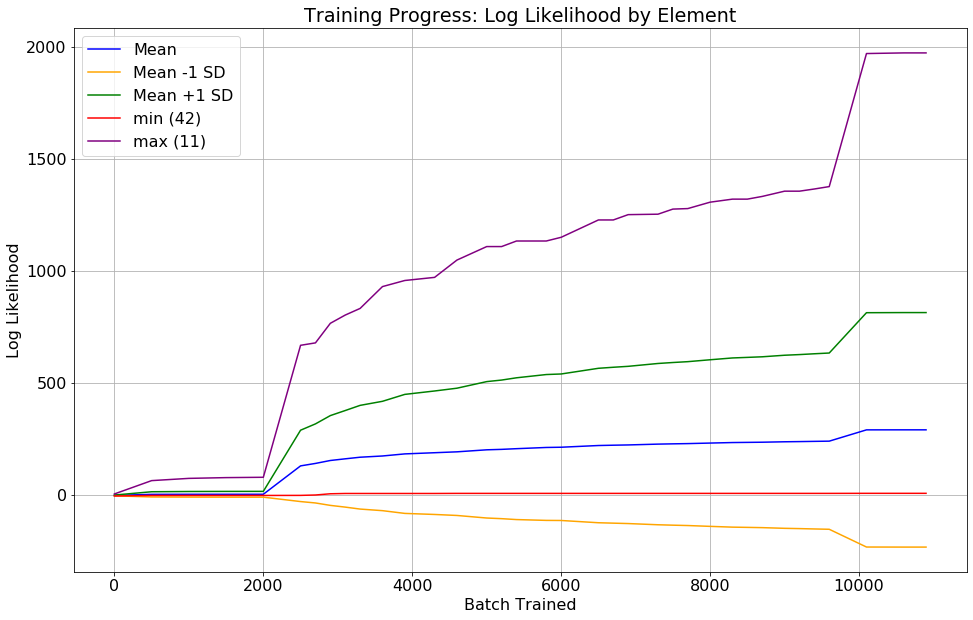

In [45]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

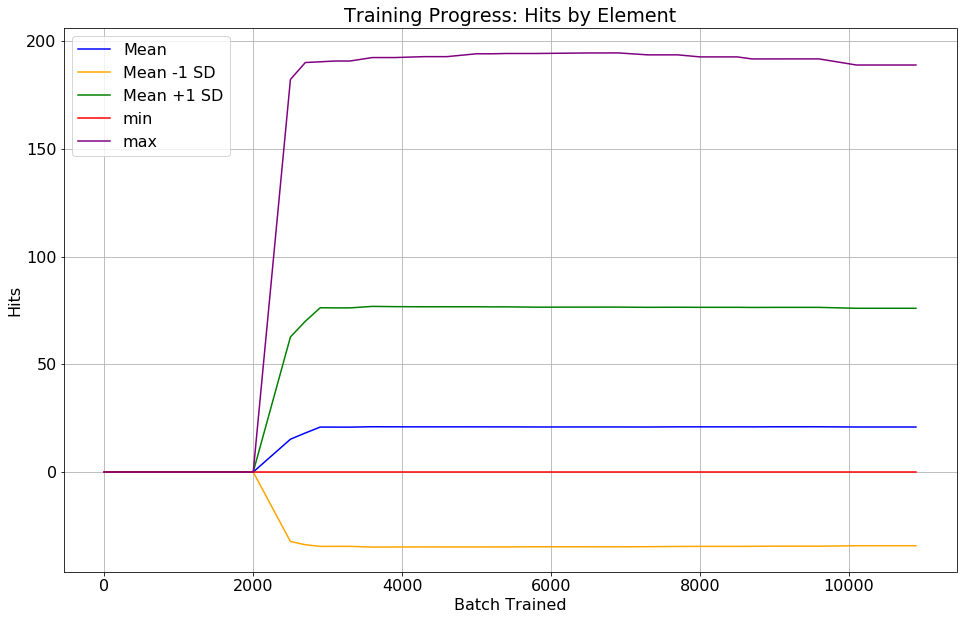

In [46]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [47]:
# Find nearest asteroid to fitted elements
elts_fit, elts_near = model.nearest_ast()

In [52]:
# Review asteroids nearest to the fitted elements
elts_near

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch
0,51921,252633,2001 XQ213,0.010623,2.754397,0.238638,0.277118,4.545567,2.430909,-1.067569,58600.0
1,59244,59244,1999 CG6,0.000162,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0
2,15786,433320,2013 QS29,0.005603,2.012032,0.053278,0.333170,0.158899,5.902577,-0.276670,58600.0
3,3904,417240,2005 YV117,0.006325,2.865015,0.121253,0.167801,5.339624,1.921934,-0.945489,58600.0
4,142999,306538,1999 XY243,0.011572,2.548402,0.199448,0.254083,6.083566,1.540373,-1.695064,58600.0
...,...,...,...,...,...,...,...,...,...,...,...
59,11952,400777,2010 EF32,0.002879,2.354203,0.084298,0.044560,0.406866,2.477171,-2.923987,58600.0
60,134815,486319,2013 CU114,0.009868,2.425234,0.074032,0.268753,0.582630,0.913216,-1.538829,58600.0
61,27860,521721,2015 RA268,0.004585,2.531813,0.143296,0.069150,5.607185,3.124851,-2.330678,58600.0
62,85937,230521,2002 WM11,0.008676,2.279547,0.182369,0.409267,4.900106,3.120242,-1.902370,58600.0


In [53]:
# Review fitted elements including nearest asteroid
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,h,lam,R,R_deg,R_sec,log_like,hits,nearest_ast_num,nearest_ast_dist
0,51921,2.752253,0.223925,0.504367,4.711442,2.456334,-1.123679,58600.0,0.250000,2.586498,0.015347,0.879308,3165.509766,95.223236,0.000000,252633,0.010623
1,59244,2.634390,0.262953,0.464958,5.738061,1.772098,-1.605332,58600.0,0.095971,206135.750000,0.000054,0.003115,11.212921,1499.924194,185.943192,59244,0.000162
2,15786,2.021644,0.076429,0.393660,6.154100,0.766409,-1.216254,58600.0,0.250000,1.999846,0.017453,1.000000,3600.001221,35.629360,0.000000,433320,0.005603
3,3904,2.879171,0.130655,0.266730,5.437965,2.084437,-1.182747,58600.0,0.022461,129.551224,0.002168,0.124243,447.275146,27.621714,0.000000,417240,0.006325
4,142999,2.530572,0.196010,0.495735,0.206220,0.907179,-1.325884,58600.0,0.250000,3.102885,0.014012,0.802812,2890.121338,83.665375,0.000000,306538,0.011572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.352520,0.084191,0.126079,0.106514,2.864537,-3.023876,58600.0,0.200527,1.999846,0.017453,1.000000,3600.001221,51.795582,0.000000,400777,0.002879
60,134815,2.422591,0.109404,0.518219,0.284398,0.597674,-0.915222,58600.0,0.250000,3.890105,0.012514,0.716993,2581.175781,87.592171,0.000000,486319,0.009868
61,27860,2.525512,0.135753,0.189578,5.518264,3.280890,3.937557,58600.0,0.250000,3.888986,0.012516,0.717097,2581.547363,261.683929,0.000000,521721,0.004585
62,85937,2.258881,0.202796,0.441548,5.246821,3.070532,4.041897,58600.0,0.250000,4.305917,0.011894,0.681495,2453.381836,126.924095,0.000000,230521,0.008676


In [54]:
# Filter for only the good ones
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 60)
elts_fit[mask]

,element_id,a,e,inc,Omega,omega,f,epoch,h,lam,R,R_deg,R_sec,log_like,hits,nearest_ast_num,nearest_ast_dist
1,59244,2.634390,0.262953,0.464958,5.738061,1.772098,-1.605332,58600.0,0.095971,2.061358e+05,0.000054,0.003115,11.212921,1499.924194,185.943192,59244,0.000162
5,5817,2.406615,0.340096,0.368327,5.942330,1.445928,-1.738007,58600.0,0.071667,7.848501e+05,0.000028,0.001596,5.746482,1696.184326,188.985184,5817,0.000274
11,9936,3.079147,0.184776,0.268932,5.416854,0.245431,0.722770,58600.0,0.047500,1.373156e+07,0.000007,0.000382,1.373838,1974.176880,172.996277,9936,0.000107
21,77774,3.200372,0.151376,0.424101,5.821290,0.026223,0.727284,58600.0,0.097606,2.256406e+05,0.000052,0.002977,10.717336,1320.285400,163.977310,77774,0.001267
25,203722,3.171834,0.291842,0.426110,5.309447,1.791934,-1.164613,58600.0,0.072272,2.076225e+06,0.000017,0.000981,3.533118,1612.647949,161.962555,203722,0.000144
40,31539,3.216137,0.178824,0.297351,5.773842,5.038750,1.789521,58600.0,0.051009,3.139115e+06,0.000014,0.000798,2.873372,1541.434814,153.995987,31539,0.000450
47,733,3.399252,0.059550,0.354061,5.951499,3.308426,3.710682,58600.0,0.108633,9.522348e+06,0.000008,0.000458,1.649770,1797.802124,150.999481,733,0.000146
50,6455,2.240817,0.572585,0.651762,0.470415,4.585713,0.184834,58600.0,0.054564,1.339698e+07,0.000007,0.000386,1.390888,1729.439941,149.995377,6455,0.000042


In [55]:
# Filter for incomplete convergence
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
elts_fit[mask]

,element_id,a,e,inc,Omega,omega,f,epoch,h,lam,R,R_deg,R_sec,log_like,hits,nearest_ast_num,nearest_ast_dist
7,5179,2.382653,0.037151,0.109490,5.722489,3.551719,3.257203,58600.0,0.25,3.466913,0.013256,0.759494,2734.179932,294.497864,0.0,134261,0.003011
14,14692,2.773103,0.028743,0.152138,6.218763,1.993204,-1.650805,58600.0,0.25,5.761855,0.010282,0.589133,2120.880371,413.783234,0.0,151856,0.003236
18,4133,2.427741,0.140447,0.199983,5.584999,4.368729,2.893211,58600.0,0.25,4.413342,0.011749,0.673150,2423.338867,256.884338,0.0,37191,0.005532
24,2015,2.340165,0.135930,0.214553,6.121816,4.780841,1.825897,58600.0,0.25,4.777803,0.011292,0.646965,2329.075684,256.323303,0.0,2015,0.003345
54,2294,2.680269,0.106350,0.097237,5.060393,0.813959,0.345727,58600.0,0.25,3.186101,0.013827,0.792258,2852.128418,349.634460,0.0,1037790,0.003327
61,27860,2.525512,0.135753,0.189578,5.518264,3.280890,3.937557,58600.0,0.25,3.888986,0.012516,0.717097,2581.547363,261.683929,0.0,521721,0.004585
63,72911,3.220282,0.172588,0.253928,5.284524,2.048176,-0.994343,58600.0,0.25,8.371410,0.008530,0.488759,1759.533081,377.751343,0.0,424231,0.007850


In [ ]:
# Calculate error vs. true elements
hist_err, q_err = model.calc_error(elts_fit_near)

In [ ]:
hist_err
mask2 = (hist_err.episode == 35)
hist_err2 = hist_err[mask2]
hist_err3 = hist_err2.loc[35*64+elts_fit[mask].index.values]
hist_err3.loc[:, ['a_err', 'a_log_err', 'e_err', 'e_log_err', 'inc_err', 'inc_log_err', 'Omega_err', 'Omega_log_err', 'omega_err','omega_log_err', 'f_err', 'f_log_err']]

In [ ]:
hist_err.columns

In [ ]:
hist_err.loc[:, ['a_err', 'a_log_err', 'e_err', 'e_log_err', 'inc_err', 'inc_log_err', 'Omega_err', 'Omega_log_err', 'omega_err','omega_log_err', 'f_err', 'f_log_err']]

In [ ]:
q_err

## Visualize Error vs. Nearest Asteroid

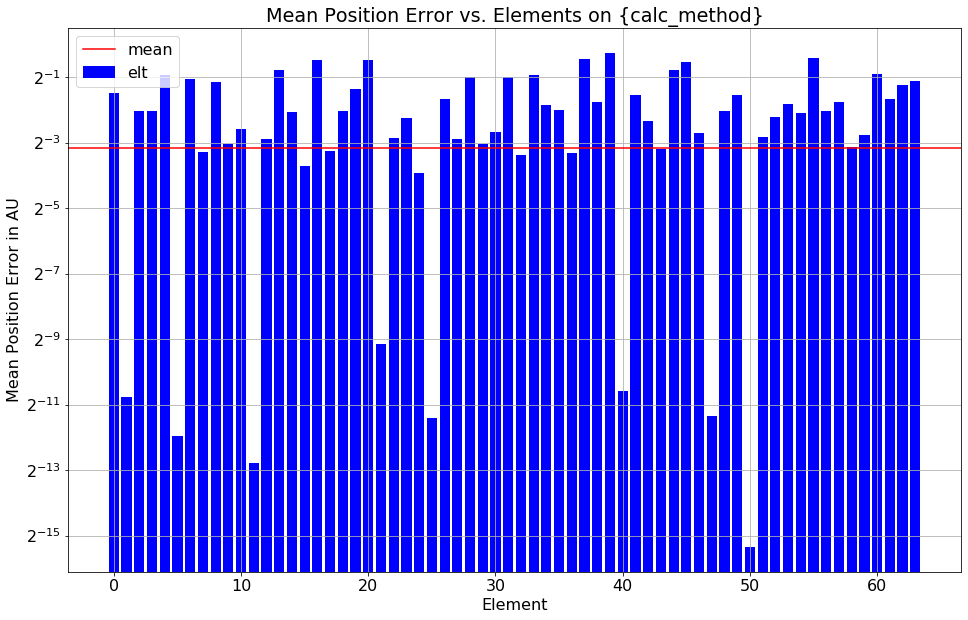

In [67]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(elts_true=model.elts_near_ast, is_log=True, use_near_ast_dist=False)

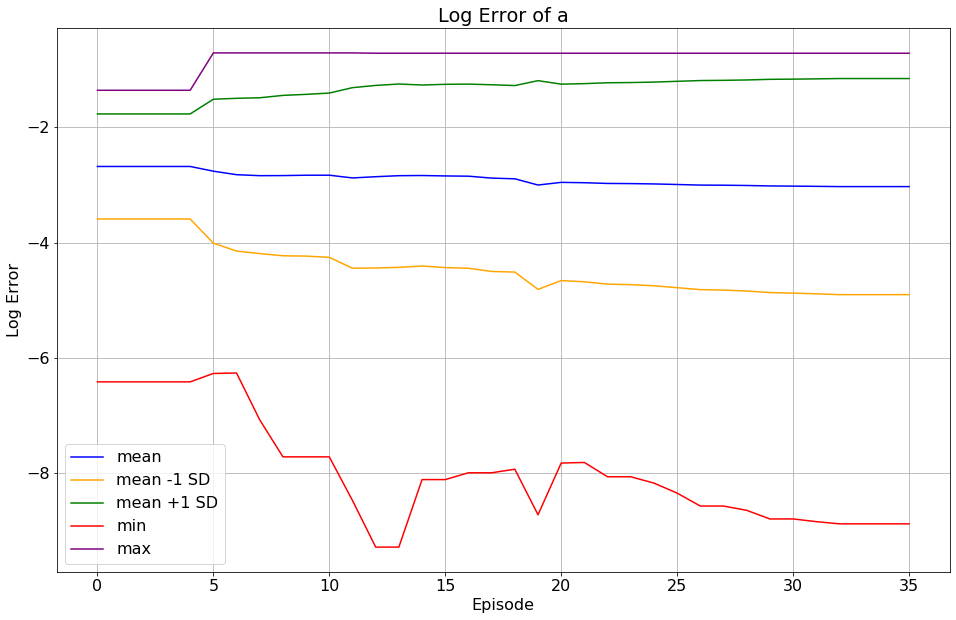

In [68]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elts_true=elts_ast, elt_name='a', is_log=True, elt_num=None)

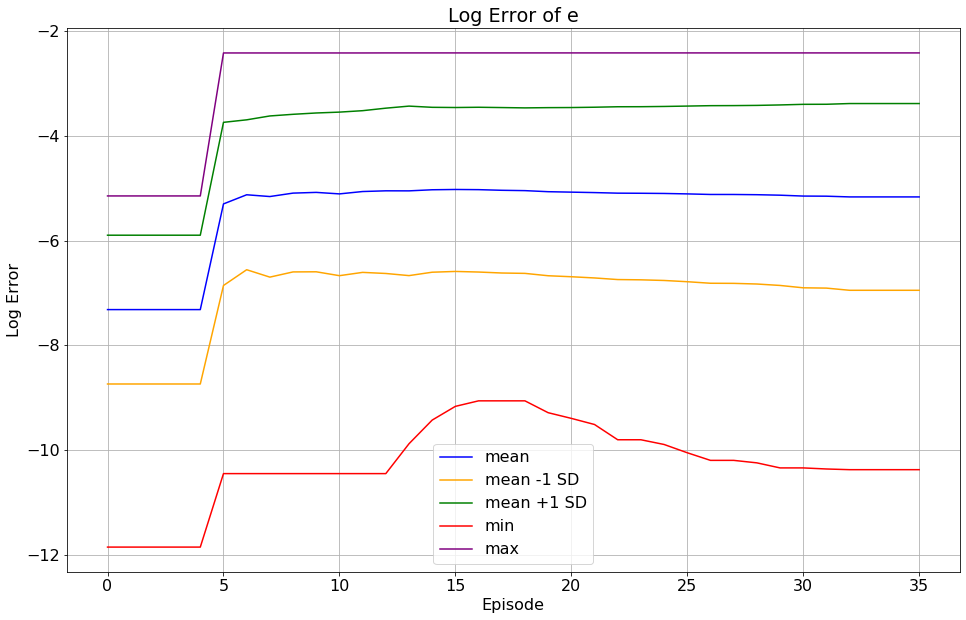

In [69]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elts_true=elts_ast, elt_name='e', is_log=True, elt_num=None)